In [31]:
import pandas as pd
df = pd.read_csv ('./IMDB-Dataset.csv')
df.info()
# Remove duplicate rows
df = df.drop_duplicates ()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 49582 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [5]:
%pip install nltk

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ---------------------------------- ----- 1.3/1.5 MB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 3.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip install beautifulsoup4


  Using cached beautifulsoup4-4.12.3-py3-none-any.whl.metadata (3.8 kB)
Using cached beautifulsoup4-4.12.3-py3-none-any.whl (147 kB)


In [10]:
%pip install contractions

Note: you may need to restart the kernel to use updated packages.


## Làm sạch dữ liệu

In [47]:
import re
import string
import nltk
nltk.download('stopwords')
nltk.download ('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions
stop = set(stopwords.words('english'))

# Expanding contractions
def expand_contractions (text) :
    return contractions.fix(text)

# Function to clean data
def preprocess_text (text) :
    wl = WordNetLemmatizer ()

    soup = BeautifulSoup (text , "html.parser") # Removing html tags
    text = soup.get_text ()
    text = expand_contractions ( text )
    # Expanding chatwords and contracts clearing contractions
    emoji_clean = re. compile ("["
        u"\U0001F600-\U0001F64F " # emoticons
        u"\U0001F300-\U0001F5FF " # symbols & pictographs
        u"\U0001F680-\U0001F6FF " # transport & map symbols
        u"\U0001F1E0-\U0001F1FF " # flags (iOS)
        u"\U00002702-\U000027B0 "
        u"\U000024C2-\U0001F251 "
        "]+", flags =re.UNICODE )
    text = emoji_clean.sub(r'',text )
    text = re.sub (r'\.(?=\S)', '.' ,text ) #add space after full stop
    text = re.sub (r'http\S+', '', text ) # remove urls
    text = " ". join ([
    word.lower () for word in text if word not in string.punctuation
    ]) # remove punctuation and make text lowercase
    text = " ". join ([
    wl. lemmatize ( word ) for word in text.split () if word not in stop and word .
isalpha () ]) # lemmatize
    return text

df['review'] = df['review'].apply (preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dinht\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dinht\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [46]:
df['review']


0                                                         
1        awonderfullittleproductionthefilmingtechniquei...
2                                                         
3                                                         
4        pettermatteisloveinthetimeofmoneyisavisuallyst...
                               ...                        
49995                                                     
49996    badplotbaddialoguebadactingidioticdirectingthe...
49997    iamacatholictaughtinparochialelementaryschools...
49998                                                     
49999    nooneexpectsthestartrekmoviestobehighartbutthe...
Name: review, Length: 49582, dtype: object

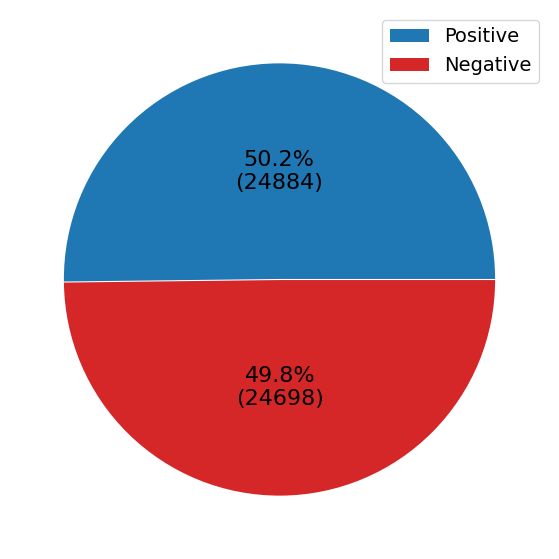

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Creating autocpt arguments
def func (pct , allvalues ) :
    absolute = int( pct / 100.* np. sum( allvalues ) )
    return "{:.1f}%\n({:d})". format (pct , absolute )

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])
data = [freq_pos , freq_neg]

labels = ['positive', 'negative']
# Create pie chart
pie , ax = plt.subplots (figsize =[11,7])
plt.pie(x=data , autopct = lambda pct: func (pct , data ) , explode =[0.0025]*2 ,
    pctdistance =0.5 , colors =[sns. color_palette () [0] , 'tab:red'] , textprops ={'fontsize': 16})
# plt.title ( ’ Frequencies of sentiment labels ’, fontsize =14 , fontweight = ’ bold ’)
labels = [r'Positive', r'Negative']
plt.legend (labels , loc ="best", prop ={'size': 14})
pie.savefig ("PieChart.png")
plt.show ()

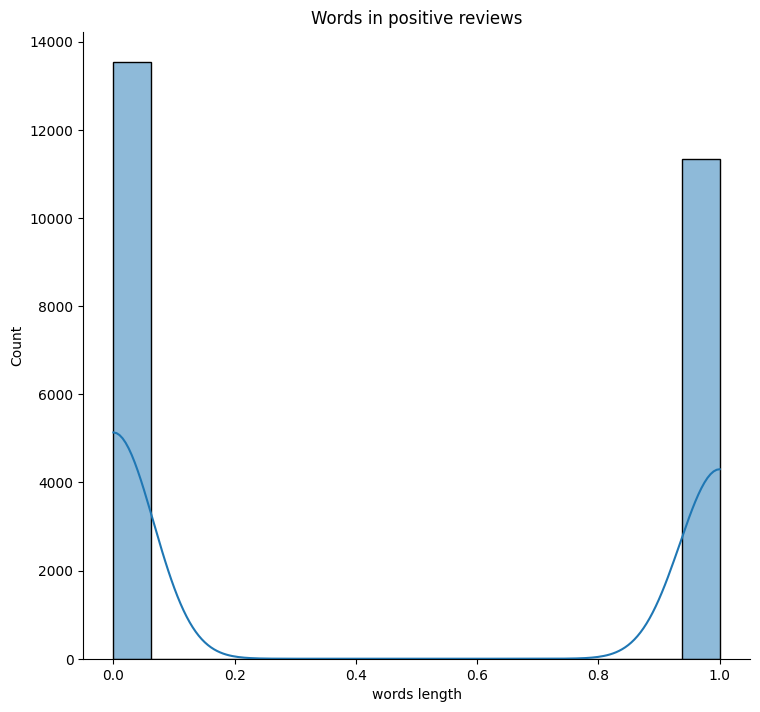

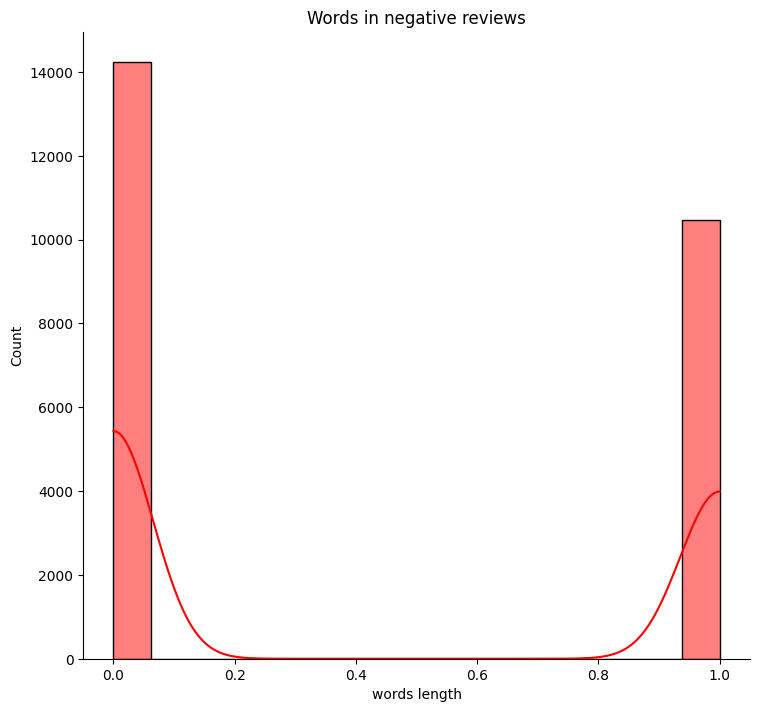

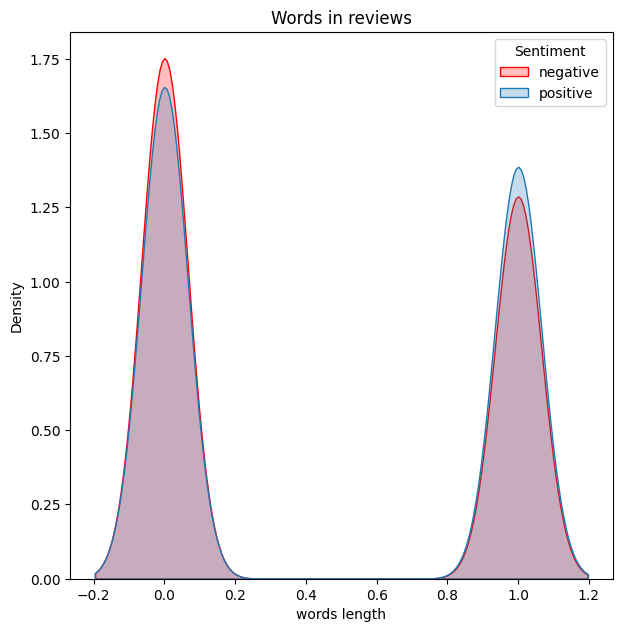

In [26]:
words_len = df['review'].str.split ().map( lambda x: len(x) )
df_temp = df.copy ()
df_temp ['words length'] = words_len

hist_positive = sns.displot (
    data = df_temp [df_temp ['sentiment'] == 'positive'] ,
    x="words length", hue="sentiment", kde=True , height =7 , aspect =1.1 , legend = False
).set ( title ='Words in positive reviews')
plt.show (hist_positive )
hist_negative = sns.displot (
    data = df_temp[df_temp ['sentiment'] == 'negative'] ,
    x="words length", hue="sentiment", kde=True , height =7 , aspect =1.1 , legend =
    False , palette =['red']
).set ( title ='Words in negative reviews')
plt.show ( hist_negative )

plt.figure ( figsize =(7,7.1) )
kernel_distibution_number_words_plot = sns. kdeplot (
    data = df_temp , x="words length", hue="sentiment", fill =True , palette =[sns.color_palette () [0] , 'red']
) .set ( title ='Words in reviews')
plt.legend (title ='Sentiment', labels =['negative', 'positive'])
plt.show (kernel_distibution_number_words_plot )

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
x_data=df['review']
label_encode = LabelEncoder ()
y_data = label_encode.fit_transform (df['sentiment'])
                                          
x_train , x_test , y_train , y_test = train_test_split (
    x_data , y_data , test_size =0.2 , random_state =42
)

In [29]:
tfidf_vectorizer = TfidfVectorizer ( max_features =10000)
tfidf_vectorizer.fit ( x_train , y_train )

x_train_encoded = tfidf_vectorizer.transform ( x_train )
x_test_encoded = tfidf_vectorizer.transform ( x_test )

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

dt_classifier = DecisionTreeClassifier (
    criterion ='entropy',
    random_state =42
)
dt_classifier.fit( x_train_encoded , y_train )
y_pred = dt_classifier.predict ( x_test_encoded )
accuracy_score (y_pred , y_test )

0.5020671574064738